In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
import copy
import time
from tqdm import tqdm  # The loading bar library

In [8]:
DATA_DIR = "../content/processed_data"
LABELED_CSV = "../content/annotated_concepts_filled.csv"
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# 1. Define the Custom Dataset (Handles both Labeled and Unlabeled data)
class HybridDataset(Dataset):
    def __init__(self, root_dir, labeled_csv=None, transform=None, mode="train"):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.samples = []
        self.class_map = {"Hemorrhagic": 0, "Ischemic": 1, "Tumor": 2}
        
        # Load all images (Unlabeled Pool)
        for cls_name, cls_idx in self.class_map.items():
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_folder): continue
            
            fnames = [f for f in os.listdir(cls_folder) if f.endswith(".jpg")]
            for f in fnames:
                self.samples.append((os.path.join(cls_folder, f), cls_idx))
        
        # Load Labeled Annotations (The 30 seed images)
        self.labeled_data = {}
        if labeled_csv:
            df = pd.read_csv(labeled_csv)
            for _, row in df.iterrows():
                # Map filename back to full path
                # CSV format: "Hemorrhagic_real_340.jpg" -> Need to find where it is
                # Note: Our CSV includes class prefix, but file on disk might be different.
                # Let's rely on the filename matching.
                
                # Concept Vector: [Hyper, Hypo, Mass, Shift]
                concepts = torch.tensor([
                    row['has_hyperdensity'], 
                    row['has_hypodensity'], 
                    row['has_mass_effect'], 
                    row['has_midline_shift']
                ], dtype=torch.float32)
                
                self.labeled_data[row['filename']] = concepts

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        # Check if this image has a concept label
        filename_key = os.path.basename(img_path)
        # We need to match the key from the CSV (which might have class prefix)
        # Simplified matching:
        concepts = torch.tensor([-1, -1, -1, -1], dtype=torch.float32) # -1 means "Unlabeled"
        
        # Try to find specific label in our dictionary
        # (In a real app, we'd map paths more robustly)
        for key in self.labeled_data:
            if key in img_path or img_path.endswith(key):
                 concepts = self.labeled_data[key]
                 break
                 
        return image, label, concepts

In [10]:
# 2. Define the SS-CBM Model Architecture
class SSCBM(nn.Module):
    def __init__(self, num_concepts=4, num_classes=3):
        super(SSCBM, self).__init__()
        
        # A. Backbone (ResNet50) - Extracts Features
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1]) # Remove last layer
        
        # B. Concept Bottleneck Layer
        # Input: 2048 features -> Output: 4 Concepts (Sigmoid 0-1)
        self.concept_layer = nn.Linear(2048, num_concepts)
        
        # C. Classifier Layer
        # Input: 4 Concepts -> Output: 3 Classes
        self.classifier = nn.Linear(num_concepts, num_classes)
        
    def forward(self, x):
        # 1. Get Features
        features = self.backbone(x)
        features = features.view(features.size(0), -1) # Flatten
        
        # 2. Predict Concepts
        concept_logits = self.concept_layer(features)
        concept_probs = torch.sigmoid(concept_logits) # Ensure 0-1 range
        
        # 3. Predict Class (using ONLY concepts)
        class_logits = self.classifier(concept_probs)
        
        return class_logits, concept_probs

In [11]:
def train_sscbm():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # A. Prepare Data Split
    full_dataset = HybridDataset(DATA_DIR, LABELED_CSV, transform=transform)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    
    # B. Setup Model
    model = SSCBM(num_concepts=4, num_classes=3).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion_task = nn.CrossEntropyLoss()
    criterion_concept = nn.BCELoss()
    
    print(f"Starting Training on {DEVICE} ({len(train_set)} train, {len(val_set)} val samples)...")
    
    for epoch in range(EPOCHS):
        # --- TRAINING PHASE ---
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        
        # Wrap loader with tqdm for progress bar
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
        
        for images, labels, concepts in loop:
            images, labels, concepts = images.to(DEVICE), labels.to(DEVICE), concepts.to(DEVICE)
            
            optimizer.zero_grad()
            class_preds, concept_preds = model(images)
            
            # Loss Calculation
            loss_task = criterion_task(class_preds, labels)
            
            mask = concepts[:, 0] != -1
            if mask.sum() > 0:
                loss_concept = criterion_concept(concept_preds[mask], concepts[mask])
            else:
                loss_concept = 0.0
            
            total_loss = loss_task + (5.0 * loss_concept)
            
            total_loss.backward()
            optimizer.step()
            
            # Metrics
            train_loss += total_loss.item()
            _, predicted = torch.max(class_preds.data, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update bar
            loop.set_postfix(loss=total_loss.item())

        # --- VALIDATION PHASE ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                class_preds, _ = model(images)
                loss = criterion_task(class_preds, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(class_preds.data, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # --- EPOCH SUMMARY ---
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / total_train
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / total_val
        
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save
    torch.save(model.state_dict(), "neuro_sscbm_model.pth")
    print("Training Complete! Model saved.")
    return model

In [12]:
# Run it
model = train_sscbm()

d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training on cuda (4972 train, 1244 val samples)...


Epoch [1/10] Train Loss: 0.8609 | Train Acc: 68.74% | Val Loss: 0.8333 | Val Acc: 71.14%


Epoch [2/10] Train Loss: 0.8293 | Train Acc: 69.57% | Val Loss: 0.8131 | Val Acc: 71.06%


Epoch [3/10] Train Loss: 0.8083 | Train Acc: 69.69% | Val Loss: 0.8050 | Val Acc: 71.22%


Epoch [4/10] Train Loss: 0.7903 | Train Acc: 69.67% | Val Loss: 0.7817 | Val Acc: 70.02%


Epoch [5/10] Train Loss: 0.7712 | Train Acc: 69.67% | Val Loss: 0.7575 | Val Acc: 71.22%


Epoch [6/10] Train Loss: 0.7550 | Train Acc: 69.65% | Val Loss: 0.7422 | Val Acc: 70.98%


Epoch [7/10] Train Loss: 0.7374 | Train Acc: 69.65% | Val Loss: 0.7486 | Val Acc: 69.37%


Epoch [8/10] Train Loss: 0.7190 | Train Acc: 73.49% | Val Loss: 0.7079 | Val Acc: 98.95%


Epoch [9/10] Train Loss: 0.7032 | Train Acc: 99.44% | Val Loss: 0.6914 | Val Acc: 100.00%


Epoch [10/10] Train Loss: 0.6872 | Train Acc: 99.90% | Val Loss: 0.6764 | Val Acc: 100.00%
Training Complete! Model saved.


Generating predictions for Evaluation...


Evaluating: 100%|██████████| 39/39 [00:05<00:00,  6.63it/s]



FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Hemorrhagic       1.00      1.00      1.00       378
    Ischemic       1.00      1.00      1.00       380
       Tumor       1.00      1.00      1.00       486

    accuracy                           1.00      1244
   macro avg       1.00      1.00      1.00      1244
weighted avg       1.00      1.00      1.00      1244



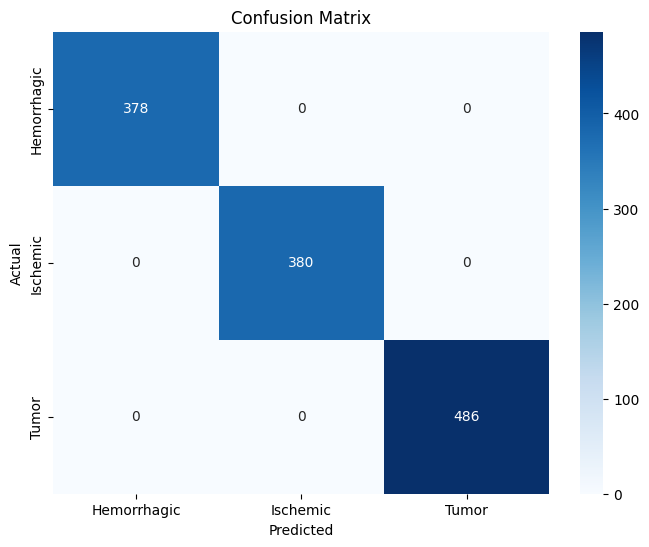

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_performance(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    # 1. Get Predictions
    print("Generating predictions for Evaluation...")
    with torch.no_grad():
        for images, labels, _ in tqdm(val_loader, desc="Evaluating"):
            images = images.to(DEVICE)
            class_logits, _ = model(images)
            _, preds = torch.max(class_logits, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # 2. Print Classification Report
    class_names = ["Hemorrhagic", "Ischemic", "Tumor"]
    print("\n" + "="*60)
    print("FINAL CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 3. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Setup validation loader again (in case it wasn't saved globally)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = HybridDataset(DATA_DIR, LABELED_CSV, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_set = random_split(full_dataset, [train_size, val_size])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

# Run Evaluation
evaluate_performance(model, val_loader)

d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
d:\Gam3a\Senior2\Neuroengineer\project\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the

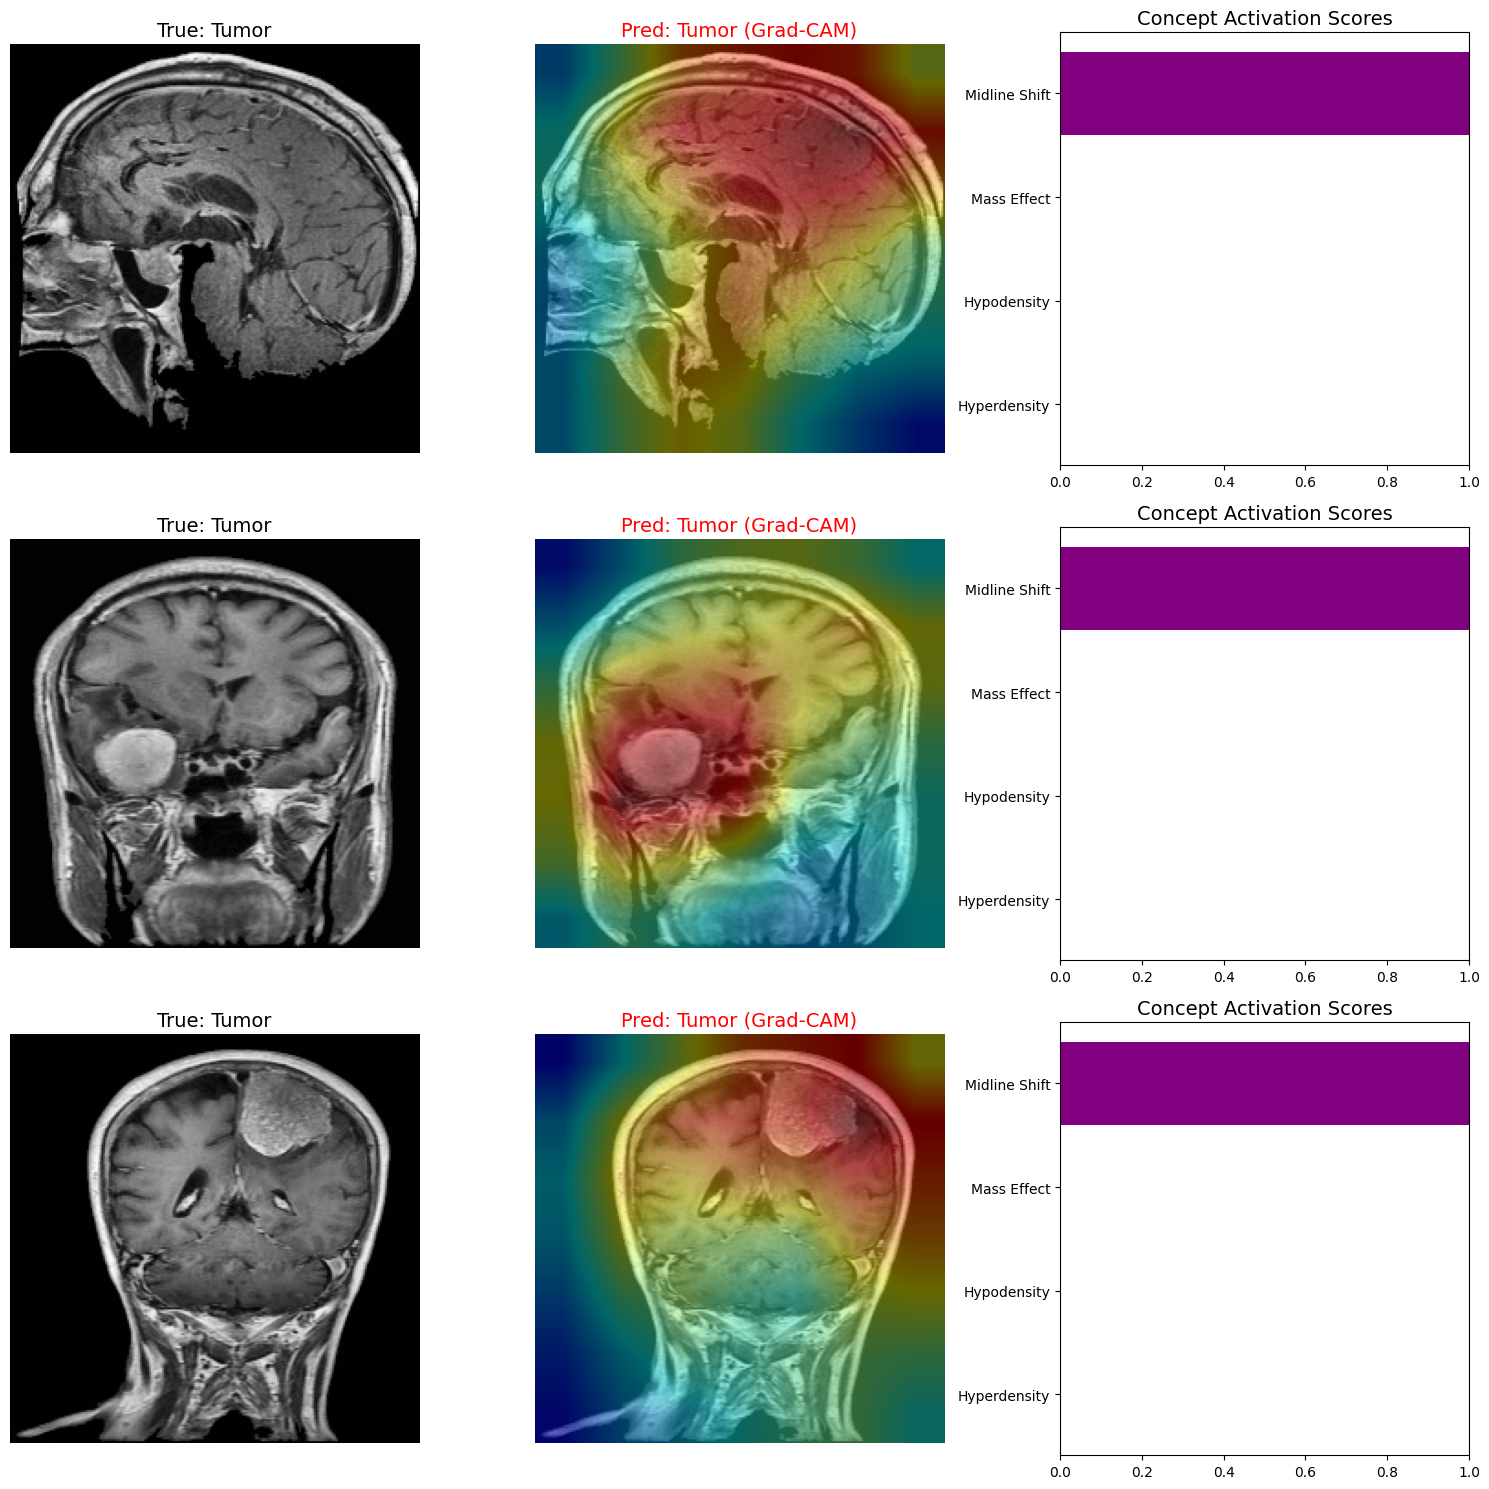

In [14]:
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hook for gradients
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # 1. Forward Pass
        self.model.zero_grad()
        class_logits, _ = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(class_logits)
            
        # 2. Backward Pass (Targeting the predicted class score)
        score = class_logits[0, class_idx]
        score.backward()
        
        # 3. Generate Map
        # Pool gradients across channels
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Weight the activations by gradients
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
            
        # Average the channels to get the heatmap
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        
        # ReLU (Keep only positive influence)
        heatmap = np.maximum(heatmap, 0)
        
        # Normalize
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
            
        return heatmap, class_idx.item()

def visualize_gradcam(model, dataset, num_samples=3):
    model.eval()
    
    # We target the last convolutional block of ResNet (layer4)
    # In model.backbone (Sequential), this is index -2 (index -1 is AvgPool)
    target_layer = model.backbone[-2] 
    grad_cam = GradCAM(model, target_layer)
    
    class_names = ["Hemorrhagic", "Ischemic", "Tumor"]
    
    # Pick random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, idx in enumerate(indices):
        image_tensor, label_idx, concepts = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE) # Add batch dim
        
        # Generate Heatmap
        heatmap, pred_idx = grad_cam(input_tensor)
        
        # Get raw image for display (Undo Normalization)
        img_disp = image_tensor.permute(1, 2, 0).numpy()
        img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_disp = np.clip(img_disp, 0, 1)
        
        # Overlay Heatmap
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
        
        superimposed = 0.6 * img_disp + 0.4 * heatmap_colored
        
        # Plot
        # 1. Original
        ax1 = plt.subplot(num_samples, 3, i*3 + 1)
        ax1.imshow(img_disp)
        ax1.set_title(f"True: {class_names[label_idx]}", fontsize=14)
        ax1.axis('off')
        
        # 2. Grad-CAM
        ax2 = plt.subplot(num_samples, 3, i*3 + 2)
        ax2.imshow(superimposed)
        ax2.set_title(f"Pred: {class_names[pred_idx]} (Grad-CAM)", fontsize=14, color='red')
        ax2.axis('off')
        
        # 3. Explainability (Concepts)
        # We need to run a forward pass again to get concept scores
        with torch.no_grad():
            _, concept_probs = model(input_tensor)
        
        c_scores = concept_probs.cpu().numpy()[0]
        concept_names = ["Hyperdensity", "Hypodensity", "Mass Effect", "Midline Shift"]
        
        ax3 = plt.subplot(num_samples, 3, i*3 + 3)
        y_pos = np.arange(len(concept_names))
        ax3.barh(y_pos, c_scores, color='purple')
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(concept_names)
        ax3.set_xlim(0, 1)
        ax3.set_title("Concept Activation Scores", fontsize=14)

    plt.tight_layout()
    plt.show()

# Run Visualization
visualize_gradcam(model, val_set, num_samples=3)